**Data prepertion : Police Press releases**

Opening file

In [5]:
import pandas as pd

df = pd.read_csv('combined_press_releases_final.csv')
print("First 5 rows:")
print(df.head())


First 5 rows:
   release_id                                           og_title  \
0           1  Collision between a car and a motorbike in Żur...   
1           1  Collision between a car and a motorbike in Żur...   
2           2                    Car-motorcycle traffic accident   
3           2                    Car-motorcycle traffic accident   
4           3              Car-motorcycle collision in Ħal Qormi   

                                          og_content og_date_published  \
0  Today, at around 0930hrs, the Police were info...        2025-10-09   
1  Today, at around 0930hrs, the Police were info...        2025-10-09   
2  Yesterday, at around 1830hrs, the Police were ...        2025-06-20   
3  Yesterday, at around 1830hrs, the Police were ...        2025-06-20   
4  Today, at around 0800hrs, the Police were info...        2025-05-12   

  og_date_modified accident_datetime  is_accident                 street  \
0       2025-10-09  09/10/2025 09:30         True  Triq 

Show basic statistics of individual accidents

In [6]:
print("Frequency of 'release_id' in the original DataFrame:")
print(df['release_id'].value_counts().sort_index())

Frequency of 'release_id' in the original DataFrame:
release_id
1      2
2      2
3      2
4      2
5      2
      ..
111    2
470    2
550    2
800    1
890    2
Name: count, Length: 115, dtype: int64


In [7]:
max_frequency = df['release_id'].value_counts().max()
print(f"The maximum frequency of any 'release_id' is: {max_frequency}")

The maximum frequency of any 'release_id' is: 4


Transform rows in columns for identical accidents

In [8]:
# Define the static columns that should be unique per release_id
static_cols = [
    'release_id', 'og_title', 'og_content', 'og_date_published',
    'og_date_modified', 'accident_datetime', 'is_accident',
    'street', 'city', 'Malta_Gozo'
]

# Define the dynamic columns that need to be expanded with prefixes
dynamic_cols = [
    'number_injured', 'accident_severity', 'vehicle_type',
    'driver_age', 'driver_gender', 'is_victim'
]

# Extract unique static columns for each release_id
df_static_unique = df[static_cols].drop_duplicates(subset=['release_id']).set_index('release_id')

# Function to process dynamic columns for each group
def process_dynamic_group(group):
    row_data = {}
    # Using uppercase letters for prefixes A, B, C...
    prefixes = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

    for i, (_, row) in enumerate(group[dynamic_cols].iterrows()):
        prefix = prefixes[i]
        for col in dynamic_cols:
            row_data[f'{prefix}_{col}'] = row[col]
    return pd.Series(row_data)

# Apply the function to each release_id group for dynamic columns
# Convert the resulting Series (with MultiIndex) to a DataFrame by unstacking
df_dynamic_processed = df.groupby('release_id').apply(process_dynamic_group, include_groups=False).unstack()

# Combine the static unique data with the processed dynamic data
df_combined = df_static_unique.merge(df_dynamic_processed, left_index=True, right_index=True, how='left')

# Reset index to make release_id a regular column again
df_combined = df_combined.reset_index()

# Display the first few rows of the combined DataFrame
print("Combined DataFrame head:")
print(df_combined.head())

# Display the number of rows in the new DataFrame
print(f"\nNumber of rows in the combined DataFrame: {len(df_combined)}")

Combined DataFrame head:
   release_id                                           og_title  \
0           1  Collision between a car and a motorbike in Żur...   
1           2                    Car-motorcycle traffic accident   
2           3              Car-motorcycle collision in Ħal Qormi   
3           4     Collision between motorcycle and car in Għaxaq   
4           5                           Car-motorcycle collision   

                                          og_content og_date_published  \
0  Today, at around 0930hrs, the Police were info...        2025-10-09   
1  Yesterday, at around 1830hrs, the Police were ...        2025-06-20   
2  Today, at around 0800hrs, the Police were info...        2025-05-12   
3  Yesterday, at around 1800hrs, the Police were ...        2025-07-30   
4  Yesterday, at around quarter to nine in the ev...        2025-04-07   

  og_date_modified accident_datetime  is_accident                  street  \
0       2025-10-09  09/10/2025 09:30        

In [9]:
print(df_combined[['release_id','A_vehicle_type','B_vehicle_type','C_vehicle_type']])

     release_id A_vehicle_type B_vehicle_type C_vehicle_type
0             1            Car      Motorbike            NaN
1             2            Car      Motorbike            NaN
2             3            Van      Motorbike            NaN
3             4            Car      Motorbike            NaN
4             5            Car      Motorbike            NaN
..          ...            ...            ...            ...
110         107      Motorbike            NaN            NaN
111         108            Car            NaN            NaN
112         109            Car            NaN            NaN
113         110            Car      E-scooter            NaN
114         111            Car            Car            NaN

[115 rows x 4 columns]


Engineer feature related to incident date/time

In [10]:
# Convert 'accident_datetime' to datetime objects, handling mixed formats and errors
df_combined['accident_datetime'] = pd.to_datetime(df_combined['accident_datetime'], format='mixed', dayfirst=True, errors='coerce')

# Extract month
df_combined['accident_month'] = df_combined['accident_datetime'].dt.month_name()

# Extract day of the week
df_combined['accident_day_of_week'] = df_combined['accident_datetime'].dt.day_name()

# Create a weekend flag (True if Saturday or Sunday)
df_combined['accident_is_weekend'] = df_combined['accident_day_of_week'].isin(['Saturday', 'Sunday'])

print("New columns added to df_combined:")
print(df_combined[['accident_datetime', 'accident_month', 'accident_day_of_week', 'accident_is_weekend']].head())

New columns added to df_combined:
    accident_datetime accident_month accident_day_of_week  accident_is_weekend
0 2025-10-09 09:30:00        October             Thursday                False
1 2025-06-19 18:30:00           June             Thursday                False
2 2025-05-12 08:00:00            May               Monday                False
3 2025-07-29 18:00:00           July              Tuesday                False
4 2025-04-06 20:45:00          April               Sunday                 True


# **Coding time of accident -->**
   - early morning: - 06:01 to 08:00
   - morning        - 08:01 to 12:00
   - afternoon:     - 12:01 to 18:00
   - evening:       - 18:01 to 21:00
   - late evening:  - 21:01 to 23:00
   - Night:         - 23:01 to 06:00

In [11]:
# Extract the hour from 'accident_datetime'

# Define a function to categorize the time of day

def categorize_time(row):
    hour = row['accident_datetime'].hour
    minute = row['accident_datetime'].minute

    # Convert time to minutes for easier comparison
    time_in_minutes = hour * 60 + minute

    if 361 <= time_in_minutes <= 480: # 06:01 (361) to 08:00 (480)
        return 'early morning'
    elif 481 <= time_in_minutes <= 720: # 08:01 (481) to 12:00 (720)
        return 'morning'
    elif 721 <= time_in_minutes <= 1080: # 12:01 (721) to 18:00 (1080)
        return 'afternoon'
    elif 1081 <= time_in_minutes <= 1260: # 18:01 (1081) to 21:00 (1260)
        return 'evening'
    elif 1261 <= time_in_minutes <= 1380: # 21:01 (1261) to 23:00 (1380)
        return 'late evening'
    else: # 23:01 (1381) to 06:00 (360)
        return 'Night'

# Apply the function to create the new 'accident_time_category' column
df_combined['accident_time_category'] = df_combined.apply(categorize_time, axis=1)

print("New 'accident_time_category' column added:")
print(df_combined[['accident_datetime', 'accident_time_category']].head())

print("\nValue counts for accident_time_category:")
print(df_combined['accident_time_category'].value_counts())


New 'accident_time_category' column added:
    accident_datetime accident_time_category
0 2025-10-09 09:30:00                morning
1 2025-06-19 18:30:00                evening
2 2025-05-12 08:00:00          early morning
3 2025-07-29 18:00:00              afternoon
4 2025-04-06 20:45:00                evening

Value counts for accident_time_category:
accident_time_category
afternoon        34
morning          33
early morning    15
evening          14
Night            11
late evening      8
Name: count, dtype: int64


# **Capture unique severity level for each incident**

Categories level (lowest to highest) -->
1. unknown
2. not injured
3. slight
4. Grievious
5. Serious
6. Fatal


In [17]:
# Define the ranking of severity levels
severity_ranking = {
    'unknown': 1,
    'not injured': 2,
    'slight': 3,
    'Grievious': 4,
    'Serious': 5,
    'Fatal': 6
}

# Create a reverse mapping for displaying the final severity
reverse_severity_ranking = {v: k for k, v in severity_ranking.items()}

# List of columns to check for accident severity (excluding the original 'accident_severity')
severity_cols_to_check = [
    'A_accident_severity',
    'B_accident_severity',
    'C_accident_severity',
    'D_accident_severity'
]

# Function to determine the highest severity
def get_highest_severity(row):
    current_severities = []
    for col in severity_cols_to_check:
        # Get the severity string, defaulting to 'unknown' if NaN
        severity_str = row[col] if pd.notna(row[col]) else 'unknown'
        current_severities.append(severity_ranking.get(severity_str, 1)) # Default to 1 (unknown) if not in mapping

    # Find the maximum numerical severity and convert it back to string
    max_severity_rank = max(current_severities)
    return reverse_severity_ranking.get(max_severity_rank, 'unknown')

# Check if df_combined exists before proceeding
if 'df_combined' not in locals() and 'df_combined' not in globals():
    raise NameError("DataFrame 'df_combined' is not defined. Please ensure the preceding cell (cell id: cVkvsWAldAAl) that creates 'df_combined' has been executed.")

# Apply the function to create the new 'severity' column
df_combined['severity'] = df_combined.apply(get_highest_severity, axis=1)

print("First 5 rows with the new 'severity' column:")
print(df_combined[['release_id'] + severity_cols_to_check + ['severity']].head())

print("\nValue counts for the new 'severity' column:")
print(df_combined['severity'].value_counts())

First 5 rows with the new 'severity' column:
   release_id A_accident_severity B_accident_severity C_accident_severity  \
0           1         not injured             Serious                 NaN   
1           2         not injured           Grievious                 NaN   
2           3         not injured           Grievious                 NaN   
3           4         not injured           Grievious                 NaN   
4           5         not injured           Grievious                 NaN   

  D_accident_severity   severity  
0                 NaN    Serious  
1                 NaN  Grievious  
2                 NaN  Grievious  
3                 NaN  Grievious  
4                 NaN  Grievious  

Value counts for the new 'severity' column:
severity
Grievious    85
Serious      20
Fatal        10
Name: count, dtype: int64


# **One-hot code cities**

Step 1: show basic stats

Step 2: reduce to ~40 cities

Step 3: one-hot coding

Basic statistics for 'city' column:
city
Naxxar           13
Marsa             7
Paola             5
Fgura             5
Żejtun            5
St Paul’s Bay     5
Żebbuġ            4
Attard            3
Msida             3
Gudja             3
Name: count, dtype: int64

Number of unique cities: 50
Total number of incidents: 115

Pareto data (Top 10 cities):
               counts  percentage  cumulative_percentage
city                                                    
Naxxar             13   11.304348              11.304348
Marsa               7    6.086957              17.391304
Paola               5    4.347826              21.739130
Fgura               5    4.347826              26.086957
Żejtun              5    4.347826              30.434783
St Paul’s Bay       5    4.347826              34.782609
Żebbuġ              4    3.478261              38.260870
Attard              3    2.608696              40.869565
Msida               3    2.608696              43.478261
Gudja           

/tmp/ipython-input-2311638834.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(pareto_data.index, rotation=90, ha='right')


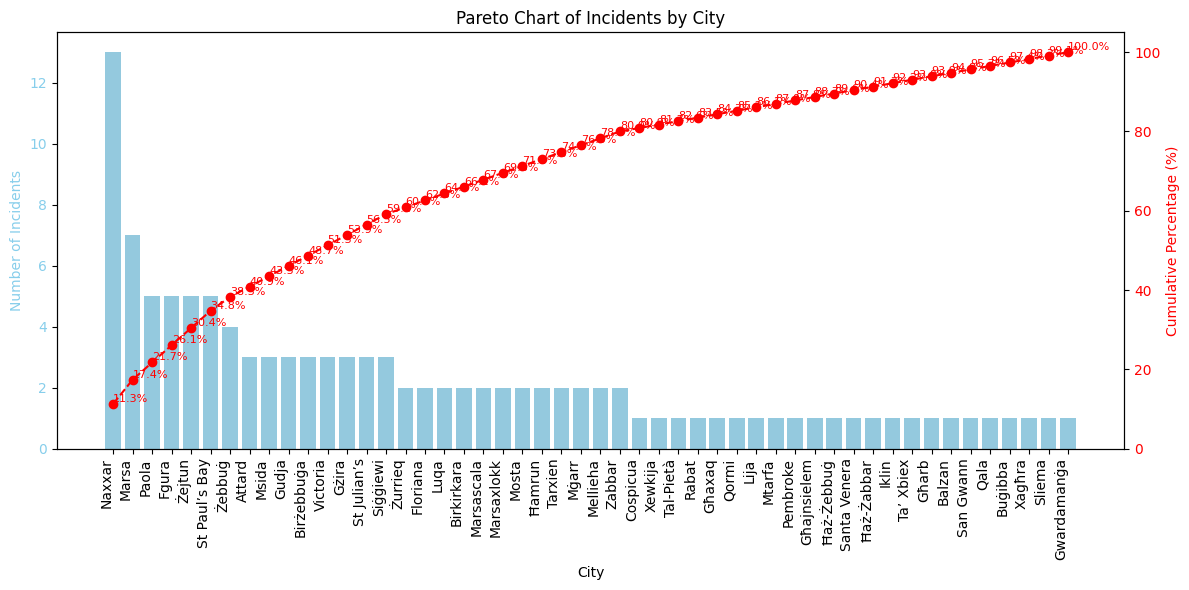

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Step 1: Display basic statistics of 'city' ---
print("Basic statistics for 'city' column:")
city_counts = df_combined['city'].value_counts()
print(city_counts.head(10)) # Display top 10 most frequent cities
print(f"\nNumber of unique cities: {df_combined['city'].nunique()}")
print(f"Total number of incidents: {len(df_combined)}")

# --- Step 2: Prepare data for Pareto chart ---
# Calculate percentages and cumulative percentages
pareto_data = pd.DataFrame({
    'counts': city_counts,
    'percentage': city_counts / len(df_combined) * 100
})
pareto_data['cumulative_percentage'] = pareto_data['percentage'].cumsum()

print("\nPareto data (Top 10 cities):")
print(pareto_data.head(10))

# --- Step 3: Plot Pareto graph ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for city counts
sns.barplot(x=pareto_data.index, y='counts', data=pareto_data, ax=ax1, color='skyblue')
ax1.set_xlabel('City')
ax1.set_ylabel('Number of Incidents', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Pareto Chart of Incidents by City')
ax1.set_xticklabels(pareto_data.index, rotation=90, ha='right')

# Create a second y-axis for the cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(pareto_data.index, pareto_data['cumulative_percentage'], color='red', marker='o', linestyle='--')
ax2.set_ylabel('Cumulative Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, 105) # Set y-axis limits for percentage

# Add cumulative percentage labels on the line
for x, y in zip(pareto_data.index, pareto_data['cumulative_percentage']):
    ax2.text(x, y, f'{y:.1f}%', color='red', ha='left', va='bottom', fontsize=8)

fig.tight_layout()
plt.show()


In [20]:
# Replace 'Ħaż-Żabbar' with 'Zabbar' in the 'city' column
df_combined['city'] = df_combined['city'].replace('Ħaż-Żabbar', 'Zabbar')

print("Updated value counts for 'city' column after replacement:")
print(df_combined['city'].value_counts().head(50))

print(f"\nNumber of unique cities after replacement: {df_combined['city'].nunique()}")

Updated value counts for 'city' column after replacement:
city
Naxxar           13
Marsa             7
Paola             5
Żejtun            5
Fgura             5
St Paul’s Bay     5
Żebbuġ            4
Gudja             3
Zabbar            3
Birżebbuġa        3
Victoria          3
Gżira             3
St Julian’s       3
Msida             3
Attard            3
Siġġiewi          3
Żurrieq           2
Birkirkara        2
Marsaxlokk        2
Mosta             2
Floriana          2
Ħamrun            2
Tarxien           2
Mġarr             2
Mellieha          2
Luqa              2
Marsascala        2
Cospicua          1
Xewkija           1
Rabat             1
Għaxaq            1
Qormi             1
Lija              1
Mtarfa            1
Tal-Pietà         1
Għajnsielem       1
Ħaż-Żebbuġ        1
Santa Venera      1
Pembroke          1
Iklin             1
Ta’ Xbiex         1
Għarb             1
Balzan            1
San Gwann         1
Qala              1
Buġibba           1
Xagħra           

In [21]:
# Step 2: Reduce 'city' column to 45 categories

num_top_cities = 45
top_cities = df_combined['city'].value_counts().nlargest(num_top_cities).index

# Create a new column 'city_reduced'
# Replace cities not in top_cities with 'Other'
df_combined['city_reduced'] = df_combined['city'].apply(lambda x: x if x in top_cities else 'Other')

print(f"Number of unique cities after reduction: {df_combined['city_reduced'].nunique()}")
print("Value counts of 'city_reduced' after reduction:")
print(df_combined['city_reduced'].value_counts())

# Step 3: One-hot encode the 'city_reduced' column
city_one_hot = pd.get_dummies(df_combined['city_reduced'], prefix='city', dtype=int)

# Merge the one-hot encoded DataFrame with the original df_combined
df_combined = pd.concat([df_combined, city_one_hot], axis=1)

print("\nFirst 5 rows of df_combined with new one-hot encoded city columns:")
print(df_combined.head())

print(f"\nNew number of columns in df_combined: {len(df_combined.columns)}")

Number of unique cities after reduction: 41
Value counts of 'city_reduced' after reduction:
city_reduced
Naxxar           13
Other             9
Marsa             7
Fgura             5
Żejtun            5
Paola             5
St Paul’s Bay     5
Żebbuġ            4
Gudja             3
Victoria          3
Gżira             3
St Julian’s       3
Siġġiewi          3
Msida             3
Attard            3
Birżebbuġa        3
Zabbar            3
Ħamrun            2
Mellieha          2
Birkirkara        2
Tarxien           2
Żurrieq           2
Mosta             2
Floriana          2
Luqa              2
Marsaxlokk        2
Mġarr             2
Marsascala        2
Rabat             1
Lija              1
Qormi             1
Għaxaq            1
Cospicua          1
Ħaż-Żebbuġ        1
Santa Venera      1
Tal-Pietà         1
Mtarfa            1
Xewkija           1
Għajnsielem       1
Iklin             1
Pembroke          1
Name: count, dtype: int64

First 5 rows of df_combined with new one-hot enc

# ***Progress so far !!***

In [22]:
print("\n--- List of Column Headers in df_combined ---")
print(df_combined.columns.tolist())

print("\n--- Summary Info for df_combined ---")
df_combined.info()

print("\n--- Descriptive Statistics for df_combined (all columns) ---")
print(df_combined.describe(include='all'))


--- List of Column Headers in df_combined ---
['release_id', 'og_title', 'og_content', 'og_date_published', 'og_date_modified', 'accident_datetime', 'is_accident', 'street', 'city', 'Malta_Gozo', 'A_accident_severity', 'A_driver_age', 'A_driver_gender', 'A_is_victim', 'A_number_injured', 'A_vehicle_type', 'B_accident_severity', 'B_driver_age', 'B_driver_gender', 'B_is_victim', 'B_number_injured', 'B_vehicle_type', 'C_accident_severity', 'C_driver_age', 'C_driver_gender', 'C_is_victim', 'C_number_injured', 'C_vehicle_type', 'D_accident_severity', 'D_driver_age', 'D_driver_gender', 'D_is_victim', 'D_number_injured', 'D_vehicle_type', 'accident_month', 'accident_day_of_week', 'accident_is_weekend', 'accident_time_category', 'severity', 'city_reduced', 'city_Attard', 'city_Birkirkara', 'city_Birżebbuġa', 'city_Cospicua', 'city_Fgura', 'city_Floriana', 'city_Gudja', 'city_Għajnsielem', 'city_Għaxaq', 'city_Gżira', 'city_Iklin', 'city_Lija', 'city_Luqa', 'city_Marsa', 'city_Marsascala', 'ci